In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras

In [2]:
df_train_full = pd.read_csv('../data/train.csv', dtype={'Id': str})
df_train_full['filename'] = '../data/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,../data/images/0560.jpg
1,4675,cup,../data/images/4675.jpg
2,0875,glass,../data/images/0875.jpg
3,4436,spoon,../data/images/4436.jpg
4,8265,plate,../data/images/8265.jpg


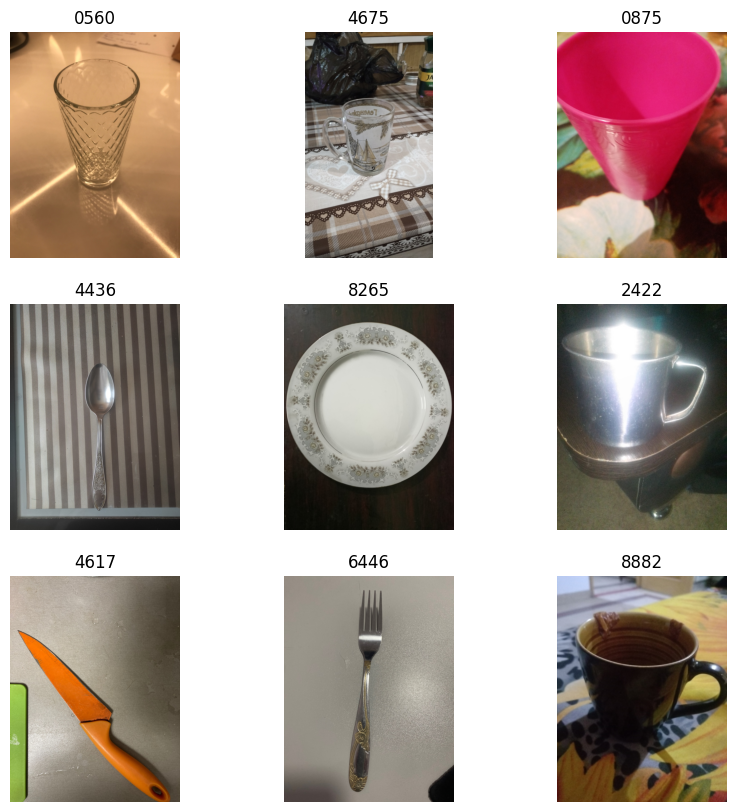

In [3]:
## Visualizing the data

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = mpimg.imread(df_train_full['filename'][i])
    plt.imshow(img)
    plt.title(df_train_full['Id'][i])
    plt.axis('off')

In [4]:
## Split the data
val_cutoff = int(len(df_train_full) * 0.8)
df_train = df_train_full[:val_cutoff]
df_val = df_train_full[val_cutoff:]

In [5]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
#Preprocess using transfer learning 
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


In [7]:
## Train generator class-indices
train_generator.class_indices

{'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}

In [8]:
## Model
## Input shape (150,150,3)
## Conv2D layer with 32 filters
## Kernel (3,3) (size of the filter)
## Activation function: relu
## MaxPooling2D layer with pool size (2,2)
## Flatten layer
## Dense layer with 64 neurons
## Activation function: relu
## Dense layer with 4 neurons
## Activation function: softmax
inputs = keras.Input(shape = (150,150,3))
x = keras.layers.Conv2D(32, (3,3), activation = 'relu')(inputs)
x = keras.layers.MaxPooling2D((2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = 'relu')(x)
outputs = keras.layers.Dense(6, activation = 'softmax')(x)

In [9]:
## As optimizer I'll use SGD with lr = 0.002 and momentum = 0.8
model = keras.Model(inputs = inputs, outputs = outputs)
lr= 0.002
momentum= 0.9
optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
#best loss function for multiclass classification:categorical_crossentropy
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [10]:
## Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                             

In [11]:
## epochs = 10

history = model.fit(train_generator, epochs = 10, validation_data = val_generator)

Epoch 1/10
139/139 [==============================] - 56s 400ms/step - loss: 1.5356 - accuracy: 0.3850 - val_loss: 1.3811 - val_accuracy: 0.4586
Epoch 2/10
139/139 [==============================] - 49s 350ms/step - loss: 1.2643 - accuracy: 0.5080 - val_loss: 1.2996 - val_accuracy: 0.4955
Epoch 3/10
139/139 [==============================] - 54s 387ms/step - loss: 1.0856 - accuracy: 0.5885 - val_loss: 1.1838 - val_accuracy: 0.5441
Epoch 4/10
139/139 [==============================] - 51s 366ms/step - loss: 0.9117 - accuracy: 0.6771 - val_loss: 1.1343 - val_accuracy: 0.5692
Epoch 5/10
139/139 [==============================] - 50s 358ms/step - loss: 0.7234 - accuracy: 0.7468 - val_loss: 1.1067 - val_accuracy: 0.5872
Epoch 6/10
139/139 [==============================] - 49s 352ms/step - loss: 0.5507 - accuracy: 0.8239 - val_loss: 1.1174 - val_accuracy: 0.5908
Epoch 7/10
139/139 [==============================] - 50s 358ms/step - loss: 0.4043 - accuracy: 0.8729 - val_loss: 1.1278 - val_ac

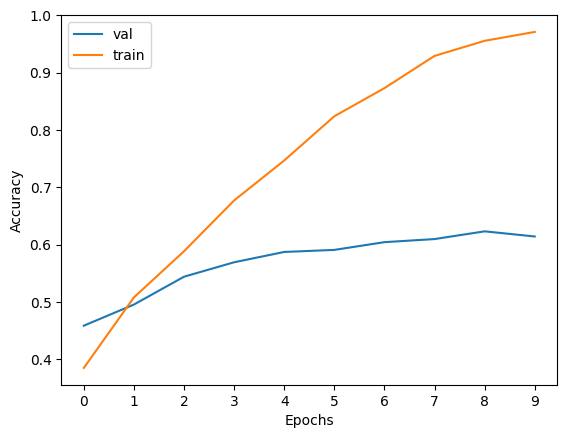

In [12]:
#plot accuracy on validation set

plt.plot(history.history['val_accuracy'], label = 'val')
plt.plot(history.history['accuracy'], label = 'train')
plt.legend()
plt.xticks(np.arange(10))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [13]:
## Adjusting the learning rate

def make_model(learning_rate = 0.01):
    inputs = keras.Input(shape = (150,150,3))
    x = keras.layers.Conv2D(32, (3,3), activation = 'relu')(inputs)
    x = keras.layers.MaxPooling2D((2,2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(64, activation = 'relu')(x)
    outputs = keras.layers.Dense(6, activation = 'softmax')(x)

    model = keras.Model(inputs = inputs, outputs = outputs)
    lr= learning_rate
    momentum= 0.9
    optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model


In [14]:
scores = {}

for lr in [0.01, 0.001, 0.0001, 0.1]:
    print(lr)
    model = make_model(learning_rate = lr)
    history = model.fit(train_generator, epochs = 10, validation_data = val_generator)
    scores[lr] = history.history
    
    print()
    print()

0.01
Epoch 1/10
139/139 [==============================] - 52s 371ms/step - loss: 1.6081 - accuracy: 0.3414 - val_loss: 1.4041 - val_accuracy: 0.4460
Epoch 2/10
139/139 [==============================] - 54s 391ms/step - loss: 1.2851 - accuracy: 0.4823 - val_loss: 1.3154 - val_accuracy: 0.4775
Epoch 3/10
139/139 [==============================] - 54s 385ms/step - loss: 1.0475 - accuracy: 0.5804 - val_loss: 1.1637 - val_accuracy: 0.5477
Epoch 4/10
139/139 [==============================] - 54s 388ms/step - loss: 0.7480 - accuracy: 0.7086 - val_loss: 1.2549 - val_accuracy: 0.5710
Epoch 5/10
139/139 [==============================] - 48s 345ms/step - loss: 0.5106 - accuracy: 0.8032 - val_loss: 1.4375 - val_accuracy: 0.5459
Epoch 6/10
139/139 [==============================] - 48s 345ms/step - loss: 0.2962 - accuracy: 0.8957 - val_loss: 1.7560 - val_accuracy: 0.5513
Epoch 7/10
139/139 [==============================] - 46s 331ms/step - loss: 0.1815 - accuracy: 0.9433 - val_loss: 1.9539 - v

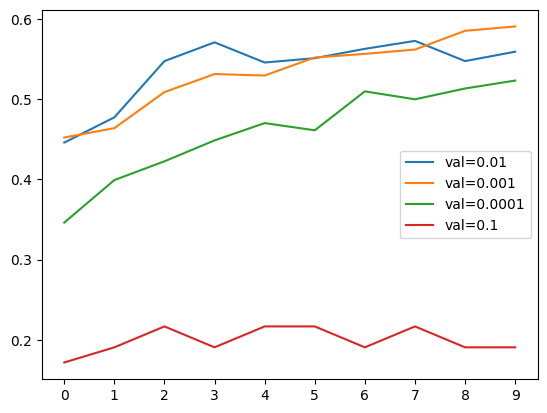

In [15]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [16]:
## Following the grapich, we can select lr = 0.01 or 0.001

lr = 0.001



In [17]:
### Checkpointing

model.save_weights('model_v1.h5', save_format='h5')

In [18]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'model_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    monitor='val_accuracy',
    save_best_only = True,
    mode = 'max'
)

In [19]:
model = make_model(learning_rate = lr)

history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = val_generator,
    callbacks = [checkpoint]
)

Epoch 1/10
139/139 [==============================] - 49s 350ms/step - loss: 1.5779 - accuracy: 0.3722 - val_loss: 1.4166 - val_accuracy: 0.4335
Epoch 2/10
139/139 [==============================] - 49s 350ms/step - loss: 1.3451 - accuracy: 0.4729 - val_loss: 1.3893 - val_accuracy: 0.4326
Epoch 3/10
139/139 [==============================] - 49s 352ms/step - loss: 1.2036 - accuracy: 0.5417 - val_loss: 1.2660 - val_accuracy: 0.4901
Epoch 4/10
139/139 [==============================] - 48s 341ms/step - loss: 1.0950 - accuracy: 0.5898 - val_loss: 1.2893 - val_accuracy: 0.5036
Epoch 5/10
139/139 [==============================] - 47s 335ms/step - loss: 0.9870 - accuracy: 0.6452 - val_loss: 1.2177 - val_accuracy: 0.5279
Epoch 6/10
139/139 [==============================] - 50s 360ms/step - loss: 0.8942 - accuracy: 0.6757 - val_loss: 1.2233 - val_accuracy: 0.5405
Epoch 7/10
139/139 [==============================] - 48s 345ms/step - loss: 0.7752 - accuracy: 0.7308 - val_loss: 1.2422 - val_ac

In [21]:
## Adding more layers
## I'll try to add one inner dense layer and experimenting with different size.

def make_model(learning_rate=0.001, size_inner = 100):
        inputs = keras.Input(shape = (150,150,3))
        x = keras.layers.Conv2D(32, (3,3), activation = 'relu')(inputs)
        x = keras.layers.MaxPooling2D((2,2))(x)
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(64, activation = 'relu')(x)

        inner = keras.layers.Dense(size_inner, activation = 'relu')(x)


        outputs = keras.layers.Dense(6, activation = 'softmax')(inner)

        model = keras.Model(inputs = inputs, outputs = outputs)
        lr= learning_rate
        momentum= 0.9
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
        model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
        return model

In [22]:
scores = {}

for size in [10,100,1000]:
    print(size)

    model = make_model(learning_rate=lr, size_inner=size)
    history = model.fit(train_generator, epochs = 10, validation_data = val_generator)
    scores[size] = history.history

    print()
    print()
    

10
Epoch 1/10
139/139 [==============================] - 47s 335ms/step - loss: 1.6960 - accuracy: 0.2854 - val_loss: 1.6034 - val_accuracy: 0.3759
Epoch 2/10
139/139 [==============================] - 46s 334ms/step - loss: 1.5415 - accuracy: 0.4054 - val_loss: 1.4657 - val_accuracy: 0.4263
Epoch 3/10
139/139 [==============================] - 49s 352ms/step - loss: 1.3945 - accuracy: 0.4675 - val_loss: 1.4098 - val_accuracy: 0.4388
Epoch 4/10
139/139 [==============================] - 45s 323ms/step - loss: 1.3148 - accuracy: 0.4862 - val_loss: 1.3566 - val_accuracy: 0.4757
Epoch 5/10
139/139 [==============================] - 50s 362ms/step - loss: 1.2103 - accuracy: 0.5296 - val_loss: 1.3196 - val_accuracy: 0.4802
Epoch 6/10
139/139 [==============================] - 47s 335ms/step - loss: 1.1206 - accuracy: 0.5633 - val_loss: 1.2966 - val_accuracy: 0.5000
Epoch 7/10
139/139 [==============================] - 48s 347ms/step - loss: 1.0442 - accuracy: 0.5977 - val_loss: 1.2591 - val

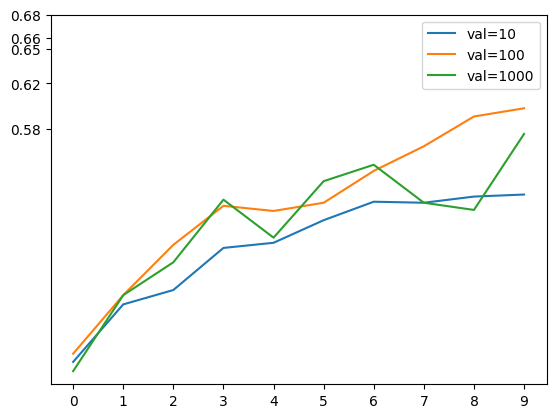

In [24]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.58, 0.62, 0.65, 0.66, 0.68])
plt.legend()

In [25]:
val = 100

## Regularization and dropout

def make_model(learning_rate=0.001, size_inner = 100, droprate = 0.5):

        inputs = keras.Input(shape = (150,150,3))
        x = keras.layers.Conv2D(32, (3,3), activation = 'relu')(inputs)
        x = keras.layers.MaxPooling2D((2,2))(x)
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(64, activation = 'relu')(x)

        inner = keras.layers.Dense(size_inner, activation = 'relu')(x)
        inner = keras.layers.Dropout(droprate)(inner)

        outputs = keras.layers.Dense(6, activation = 'softmax')(inner)

        model = keras.Model(inputs = inputs, outputs = outputs)
        lr= learning_rate
        momentum= 0.9
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
        model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
        return model

In [26]:
scores = {}

for droprate in [0.1, 0.2, 0.3, 0.4, 0.5]:

    print(droprate)

    model = make_model(learning_rate=lr, size_inner=val, droprate=droprate)
    history = model.fit(train_generator, epochs = 10, validation_data = val_generator)
    scores[droprate] = history.history

    print()
    print()

0.1
Epoch 1/10
139/139 [==============================] - 50s 354ms/step - loss: 1.6168 - accuracy: 0.3468 - val_loss: 1.4613 - val_accuracy: 0.4218
Epoch 2/10
139/139 [==============================] - 48s 341ms/step - loss: 1.4068 - accuracy: 0.4477 - val_loss: 1.3738 - val_accuracy: 0.4685
Epoch 3/10
139/139 [==============================] - 48s 346ms/step - loss: 1.2940 - accuracy: 0.4868 - val_loss: 1.3062 - val_accuracy: 0.4703
Epoch 4/10
139/139 [==============================] - 49s 350ms/step - loss: 1.1833 - accuracy: 0.5478 - val_loss: 1.2228 - val_accuracy: 0.5306
Epoch 5/10
139/139 [==============================] - 49s 349ms/step - loss: 1.0720 - accuracy: 0.5948 - val_loss: 1.1941 - val_accuracy: 0.5423
Epoch 6/10
139/139 [==============================] - 46s 333ms/step - loss: 0.9587 - accuracy: 0.6467 - val_loss: 1.1430 - val_accuracy: 0.5612
Epoch 7/10
139/139 [==============================] - 46s 328ms/step - loss: 0.8400 - accuracy: 0.6949 - val_loss: 1.1383 - va

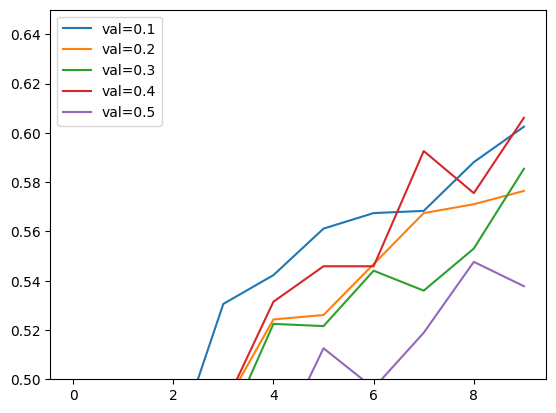

In [28]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.50, 0.65)
plt.legend()

In [29]:
droprate = 0.4

## Last model

model = make_model(learning_rate=lr, size_inner=val, droprate=droprate)
checkpoint = keras.callbacks.ModelCheckpoint(
    'model_v2_{epoch:02d}_{val_accuracy:.3f}.h5',
    monitor='val_accuracy',
    save_best_only = True,
    mode = 'max'
)

history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = val_generator,
    callbacks = [checkpoint]
)

## Let's see the results

Epoch 1/10
139/139 [==============================] - 53s 372ms/step - loss: 1.6615 - accuracy: 0.3310 - val_loss: 1.5208 - val_accuracy: 0.3867
Epoch 2/10
139/139 [==============================] - 53s 379ms/step - loss: 1.5047 - accuracy: 0.4018 - val_loss: 1.4144 - val_accuracy: 0.4371
Epoch 3/10
139/139 [==============================] - 55s 397ms/step - loss: 1.4081 - accuracy: 0.4461 - val_loss: 1.3552 - val_accuracy: 0.4505
Epoch 4/10
139/139 [==============================] - 55s 394ms/step - loss: 1.3113 - accuracy: 0.4877 - val_loss: 1.3028 - val_accuracy: 0.4820
Epoch 5/10
139/139 [==============================] - 55s 393ms/step - loss: 1.2487 - accuracy: 0.5242 - val_loss: 1.2555 - val_accuracy: 0.5036
Epoch 6/10
139/139 [==============================] - 53s 378ms/step - loss: 1.1750 - accuracy: 0.5478 - val_loss: 1.2446 - val_accuracy: 0.5072
Epoch 7/10
139/139 [==============================] - 54s 384ms/step - loss: 1.0953 - accuracy: 0.5817 - val_loss: 1.1751 - val_ac

In [ ]:
## Using the model

